In [63]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [64]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jayden\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jayden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jayden\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [65]:
raw_data = pd.read_csv('file.csv')
raw_data.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [66]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  219294 non-null  int64 
 1   tweets      219294 non-null  object
 2   labels      219294 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


Data cleaning and pre-processing

In [67]:
#drop unncessary col
df = raw_data.drop(['Unnamed: 0'], axis=1)
df

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,bad
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,chatgpt is being disassembled until it can onl...,bad
219292,2023 predictions by #chatGPT. Nothing really s...,bad


In [68]:
print("Duplicated values: " , df.duplicated().sum())

Duplicated values:  1671


In [69]:
df.drop_duplicates(inplace=True)
data = df.dropna(axis=0)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217623 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  217623 non-null  object
 1   labels  217623 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB
None


In [70]:
#lets handle contractions

stop_words = set(stopwords.words('english'))
st = PorterStemmer()
lem = WordNetLemmatizer()

# Function to handle contractions
def handle_contractions(text):
    contractions = {
        "n't": " not",
        "'s": " is",
        "'re": " are",
        "'ve": " have",
        "'d": " would",
        "'ll": " will",
        "'m": " am"
    }

    words = text.split()
    for i in range(len(words)):
            if words[i] in contractions:
                words[i] = contractions[words[i]]
    return ' '.join(words)

def is_alpha(word):
    for part in word.split('-'):
        if not part.isalpha():
            return False
    
    return True

# Function to preprocess text data
def clean_dataset(text):
    text = re.sub(r'http\S+', '', text) # removing links
    text = re.sub(r'\\n', ' ', text) # removing \\n
    text = re.sub(r"\s*#\S+", "", text) # removing hash tags
    text = re.sub(r"\s*@\S+", "", text) # removing @
    text = text.lower()
    words = [word for word in word_tokenize(text) if is_alpha(word)]
    #words = [st.stem(word) for word in words]
    words = [lem.lemmatize(word) for word in words]
    
    # text = " ".join([word for word in text.split(" ") if is_alpha(word)])
    # text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) 
    words = [w for w in words if not w in stop_words]
    text = " ".join(words)
    
    return text.strip()

df.insert(len(data.columns)-1, "processed_tweets", df['tweets'].apply(clean_dataset))
df.head()


,tweets,processed_tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language model dialogue,neutral
1,"Try talking with ChatGPT, our new AI system wh...",try talking chatgpt new ai system optimized di...,good
2,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language model dialogue tre...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",thrilled share chatgpt new model optimized dia...,good
4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad


In [71]:
df

,tweets,processed_tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language model dialogue,neutral
1,"Try talking with ChatGPT, our new AI system wh...",try talking chatgpt new ai system optimized di...,good
2,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language model dialogue tre...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",thrilled share chatgpt new model optimized dia...,good
4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
...,...,...,...
219289,Other Software Projects Are Now Trying to Repl...,software project trying replicate chatgpt,bad
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,asked write joke seos delivered seo make resol...,good
219291,chatgpt is being disassembled until it can onl...,chatgpt disassembled dissemble,bad
219292,2023 predictions by #chatGPT. Nothing really s...,prediction nothing really specific trend past ...,bad


In [72]:
#lets save as parquet for ez loading/preprocessing
df.to_parquet("df.parqguet.gzip", compression='gzip')
df_from_parquet = pd.read_parquet('df.parqguet.gzip')

Feature engineering

In [73]:
#get char and word counts for each tweet
df_from_parquet['char_count'] = df_from_parquet['processed_tweets'].apply(len)
df_from_parquet['word_count'] = df_from_parquet['processed_tweets'].apply(lambda x: len(x.split()))
df_from_parquet

,tweets,processed_tweets,labels,char_count,word_count
0,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language model dialogue,neutral,42,5
1,"Try talking with ChatGPT, our new AI system wh...",try talking chatgpt new ai system optimized di...,good,76,12
2,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language model dialogue tre...,neutral,133,17
3,"THRILLED to share that ChatGPT, our new model ...",thrilled share chatgpt new model optimized dia...,good,81,11
4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad,41,7
...,...,...,...,...,...
219289,Other Software Projects Are Now Trying to Repl...,software project trying replicate chatgpt,bad,41,5
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,asked write joke seos delivered seo make resol...,good,120,19
219291,chatgpt is being disassembled until it can onl...,chatgpt disassembled dissemble,bad,30,3
219292,2023 predictions by #chatGPT. Nothing really s...,prediction nothing really specific trend past ...,bad,71,11


In [74]:
df_from_parquet.sort_values(by='word_count', ascending=False).head()

,tweets,processed_tweets,labels,char_count,word_count
79945,Poverty can make u paranoid &amp; mad u'll sta...,poverty make u paranoid amp mad u start suspec...,bad,221,43
26425,ChatGPT to the rescue.\n\nSilicon slave\nCode ...,chatgpt rescue silicon slave code herder code ...,bad,261,41
215554,Major World Events in 2022\n\nRussia-Ukraine w...,major world event russia-ukraine war inflation...,bad,245,40
11419,Partey\nOtto Addo\nArrascaeta\nKudus\nMetro Bo...,partey otto addo arrascaeta kudu metro boomin ...,bad,264,40
119424,"Yesterday, I was happy that AI was able to gen...",yesterday wa happy ai wa able generate amazing...,good,188,39


Lets perform EDA prior to sentiment analysis 

In [75]:
from textblob import TextBlob
#get sentiment scores
df_from_parquet['Sentiment_Score'] = df_from_parquet['processed_tweets'].apply(lambda x: TextBlob(x).sentiment.polarity)

#get subject scores
df_from_parquet['Subjectivity_Score'] = df_from_parquet['processed_tweets'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [76]:
#map sentiment scores to sent labels - set ranges for threshold values
df_from_parquet['Sentiment_Label'] = df_from_parquet.apply(
    lambda row: 'Positive' if row['Sentiment_Score'] > 0 and row['Subjectivity_Score'] > 0.5 else 
                'Negative' if row['Sentiment_Score'] < 0 and row['Subjectivity_Score'] > 0.5 else 'Neutral',
    axis=1)

In [77]:
df_from_parquet

,tweets,processed_tweets,labels,char_count,word_count,Sentiment_Score,Subjectivity_Score,Sentiment_Label
0,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language model dialogue,neutral,42,5,0.000000,0.000000,Neutral
1,"Try talking with ChatGPT, our new AI system wh...",try talking chatgpt new ai system optimized di...,good,76,12,0.136364,0.454545,Neutral
2,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language model dialogue tre...,neutral,133,17,0.000000,0.000000,Neutral
3,"THRILLED to share that ChatGPT, our new model ...",thrilled share chatgpt new model optimized dia...,good,81,11,0.302273,0.479242,Neutral
4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad,41,7,0.211039,0.495130,Neutral
...,...,...,...,...,...,...,...,...
219289,Other Software Projects Are Now Trying to Repl...,software project trying replicate chatgpt,bad,41,5,0.000000,0.000000,Neutral
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,asked write joke seos delivered seo make resol...,good,120,19,-0.137879,0.618182,Negative
219291,chatgpt is being disassembled until it can onl...,chatgpt disassembled dissemble,bad,30,3,0.000000,0.000000,Neutral
219292,2023 predictions by #chatGPT. Nothing really s...,prediction nothing really specific trend past ...,bad,71,11,-0.125000,0.187500,Neutral


Lets look for keywords that may have positive and negative conotation 


In [78]:
# analyse the frequency of specific keywords or phrases in the feedback
from collections import Counter

# The keywords or phrases of interest
keywords = ['shit', 'difficult', 'terrible', 'evil', 'neat', 'okay', 'best', 'worst', 'good', 'bad', 'amazing']

# Concatenate all the preprocessed feedback into a single string
all_feedback = ' '.join(df_from_parquet['processed_tweets'])
# Tokenize the text into individual words
tokens = all_feedback.split()

# Count the frequency of each keyword in the feedback
keyword_frequency = Counter(tokens)

# Print the frequency of each keyword
for keyword in keywords:
    print(f"Frequency of '{keyword}': {keyword_frequency[keyword]}")

Frequency of 'shit': 1231
Frequency of 'difficult': 400
Frequency of 'terrible': 291
Frequency of 'evil': 285
Frequency of 'neat': 178
Frequency of 'okay': 691
Frequency of 'best': 3412
Frequency of 'worst': 210
Frequency of 'good': 8774
Frequency of 'bad': 1867
Frequency of 'amazing': 3477


Now lets cluster similar words together using a subset of 20k tweets - due to it being a very large dataset

In [79]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

subset_df = df_from_parquet.iloc[:20000,:20000]

# Apply TF-IDF vectorization to the processed tweets
tfidf_matrix = vectorizer.fit_transform(subset_df ['processed_tweets'])
tfidf_matrix = tfidf_matrix[:20000,:20000]
tfidf_matrix

<20000x16287 sparse matrix of type '<class 'numpy.float64'>'
	with 198353 stored elements in Compressed Sparse Row format>

In [80]:
# Perform K-means clustering
num_clusters = 3  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Assign cluster labels to the feedback data
subset_df['Cluster'] = kmeans.labels_
subset_df

,tweets,processed_tweets,labels,char_count,word_count,Sentiment_Score,Subjectivity_Score,Sentiment_Label,Cluster
0,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language model dialogue,neutral,42,5,0.000000,0.000000,Neutral,2
1,"Try talking with ChatGPT, our new AI system wh...",try talking chatgpt new ai system optimized di...,good,76,12,0.136364,0.454545,Neutral,0
2,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language model dialogue tre...,neutral,133,17,0.000000,0.000000,Neutral,2
3,"THRILLED to share that ChatGPT, our new model ...",thrilled share chatgpt new model optimized dia...,good,81,11,0.302273,0.479242,Neutral,0
4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad,41,7,0.211039,0.495130,Neutral,0
...,...,...,...,...,...,...,...,...,...
20049,I think if we have to add a GAN with some kind...,think add gan kind dynamic turing test,good,38,7,0.300000,0.533333,Positive,0
20050,This is crazy! \n#ChatGPT https://t.co/9O866e...,crazy,bad,5,1,-0.600000,0.900000,Negative,0
20051,"""All the news that's fit to print"". I'm shock...",news fit print shocked appears far exactly zer...,good,149,22,0.293750,0.604861,Positive,0
20052,Asked ChatGPT how crypto can help Africa.\n\nI...,asked chatgpt crypto help africa know,neutral,37,6,0.000000,0.000000,Neutral,0


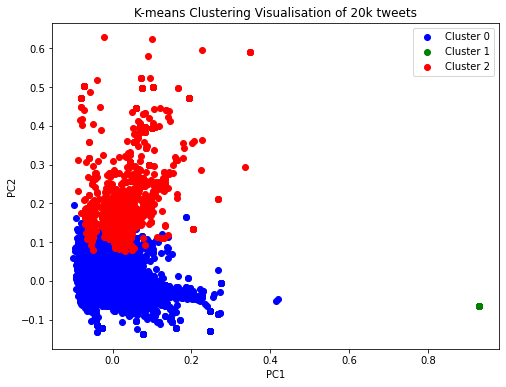

Top terms per cluster:
Cluster 0:
  chatgpt
  ai
  asked
  write
  like
  good
  google
  question
  know
  code

Cluster 1:
  chatgpt
  𝘤𝘢𝘯
  flipping
  flipante
  flip
  flight
  flickered
  flicker
  flexport
  flexing

Cluster 2:
  openai
  chatgpt
  chatbot
  new
  model
  dialogue
  optimizing
  language
  via
  ai



In [81]:
# Apply dimensionality reduction using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

cluster_names = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2'} # number of clusters
colors = ['blue', 'green', 'red']  # colours of number of clusters

plt.figure(figsize=(8, 6))

# plot each cluster separately, giving them a label that can be used in the legend
for cluster_number, color in zip(cluster_names.keys(), colors):
    plt.scatter(
        reduced_features[subset_df['Cluster'] == cluster_number, 0], 
        reduced_features[subset_df['Cluster'] == cluster_number, 1], 
        c=color, 
        label=cluster_names[cluster_number]
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering Visualisation of 20k tweets')
plt.legend()
plt.show()

# Print the top terms for each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f"  {terms[ind]}")
    print()

What about the frequency of words

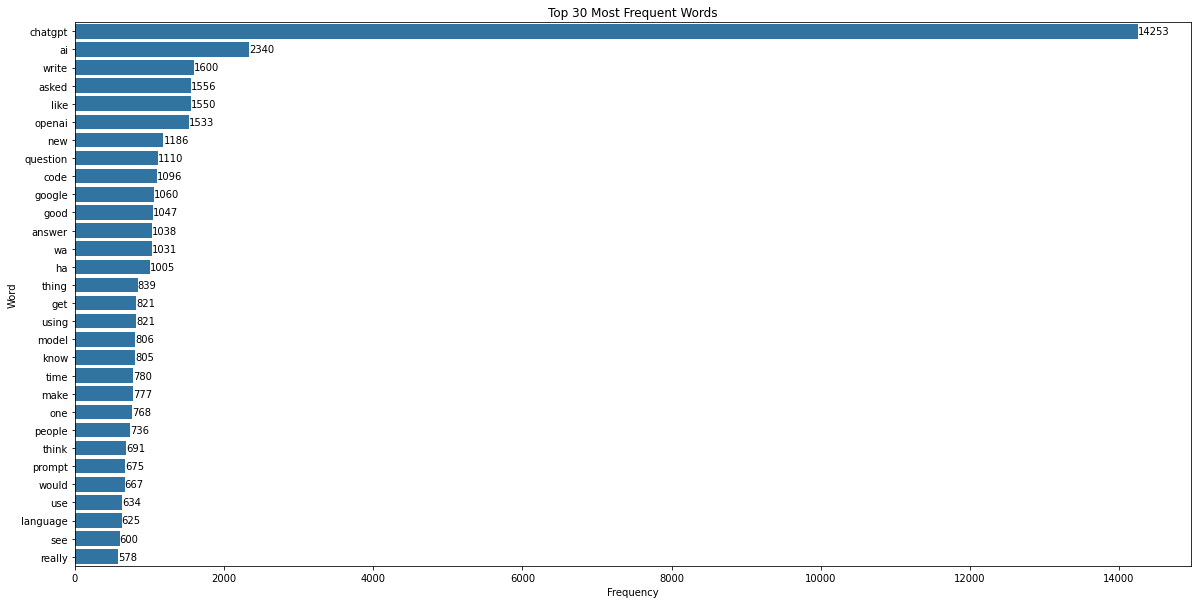

In [85]:
# Word Frequency Analysis
from collections import Counter
word_frequency = Counter(" ".join(subset_df['processed_tweets']).split()).most_common(30)
plt.figure(figsize=(20, 10))
color = sns.color_palette()[0]
ax = sns.barplot(x=[word[1] for word in word_frequency], y=[word[0] for word in word_frequency], color=color)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 30 Most Frequent Words')
plt.show()

Correlation of features

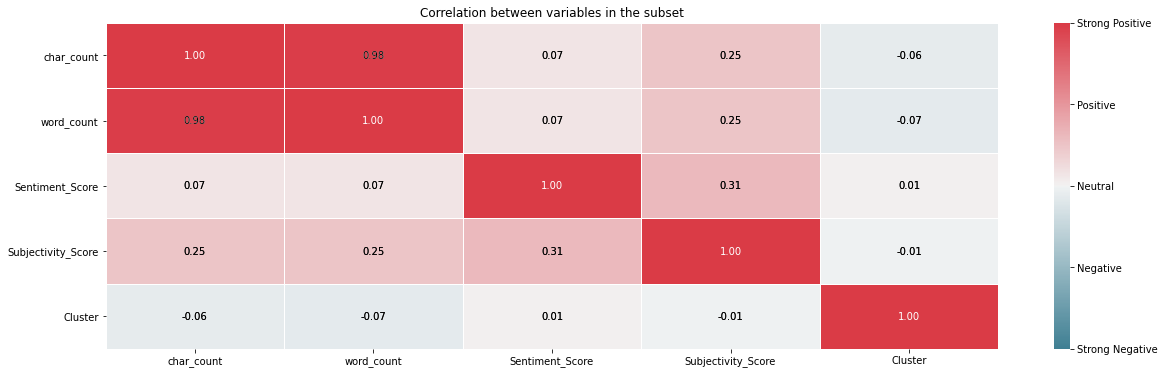

In [91]:
# correlation matrix of numerical variables in the data
correlation_matrix = subset_df.corr()

plt.figure(figsize=[20, 6])
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between variables in the subset')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.show()

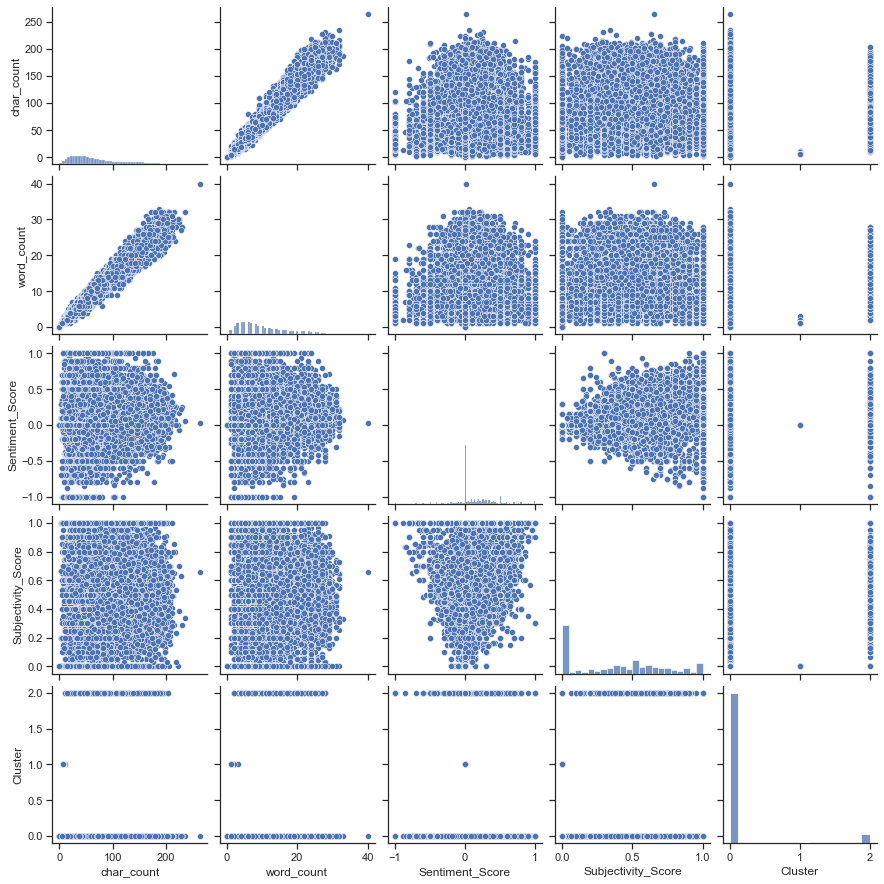

In [92]:
#pairplot vis 
sns.set(style='ticks')
sns.pairplot(subset_df)

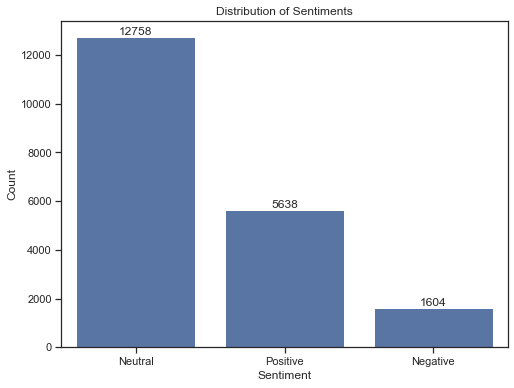

In [94]:

# Bar plot for Sentiment
plt.figure(figsize=(8, 6))
color = sns.color_palette()[0]
order = subset_df['Sentiment_Label'].value_counts().index
ax = sns.countplot(data=subset_df, x='Sentiment_Label', color=color, order=order)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

Distribution of legenth of feedback

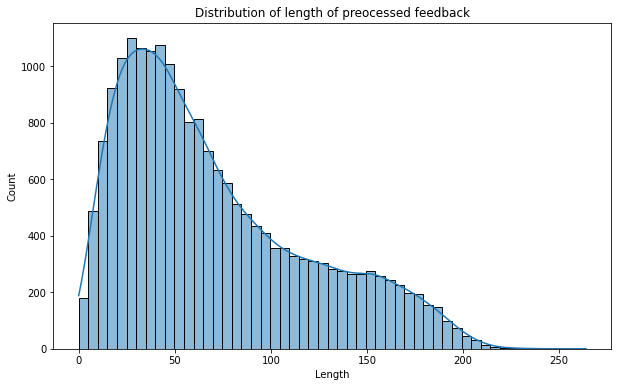

In [86]:
# Distribution of length of preocessed feedback
plt.figure(figsize=(10, 6))
sns.histplot(subset_df['char_count'], kde = True, palette = 'hls')
plt.title('Distribution of length of preocessed feedback')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()